In [8]:
### WIP



In [9]:
# https://github.com/SeldonIO/alibi-detect#drift-detection

In [10]:
# #pip  install alibi-detect --user
# # # !pip  install tensorflow
# !pip install catboost
# !pip install xgboost
# !pip install category_encoders
# # # !pip install torch torchvision torchaudio
# !pip install lightgbm


In [11]:


import alibi

from alibi_detect.cd import TabularDrift,MMDDrift
from alibi_detect.utils.saving import save_detector, load_detector


import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt    
import seaborn as sns
import category_encoders as ce
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pickle
import warnings

In [12]:
data = pd.read_csv('data.csv')
data.head(5)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,148,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,45.65,45.65,Yes
1,463,Male,0,Yes,Yes,4,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,101.15,385.90,Yes
2,471,Female,1,No,No,17,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,330.60,No
3,496,Male,0,No,No,22,No,No phone service,DSL,No,...,Yes,No,No,Yes,One year,Yes,Bank transfer (automatic),43.75,903.60,Yes
4,833,Female,0,Yes,Yes,70,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),74.10,5222.30,No


Apply encoding on categorical features

In [13]:
# do all data massaging
# Convert binary variable into numeric so plotting is easier. We need to later take mean
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

data.replace(" ", np.nan, inplace=True)

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

mean = data['TotalCharges'].mean()
data.fillna(mean, inplace=True)


names = ['gender', 'Partner', 'Dependents', 'PhoneService', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
# for column in names:
#     labelencoder(column)
data_enc = data
data_enc = data_enc.drop(['Churn', 'customerID'], axis=1)
enc = ce.ordinal.OrdinalEncoder(cols=names)
enc.fit(data_enc)
###
filename_oe = 'OrdinalEncoder_drift.sav'
pickle.dump(enc, open(filename_oe, 'wb'))
 
# some time later...
 
# load the model from disk
enc = pickle.load(open(filename_oe, 'rb'))
###
labelled_set = enc.transform(data_enc)

names = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod', 'OnlineSecurity', 'OnlineBackup',
         'DeviceProtection', 'TechSupport']

ohe = ce.OneHotEncoder(cols=names)
data_ohe = data
data_ohe = data_ohe.drop(['Churn', 'customerID'], axis=1)
ohe.fit(data_ohe)
###
filename_ohe = 'OneHotEncoder_drift.sav'
pickle.dump(ohe, open(filename_ohe, 'wb'))
 
# some time later...
 
# load the model from disk
ohe = pickle.load(open(filename_ohe, 'rb'))
###
final_set = ohe.transform(labelled_set)
columns_name =final_set.columns
final_set.head(5)





/opt/app-root/lib64/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,...,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges
0,1,0,1,1,1,1,1,0,0,1,...,1,0,0,1,1,0,0,0,45.65,45.65
1,1,0,2,2,4,1,0,1,0,0,...,1,0,0,2,1,0,0,0,101.15,385.90
2,2,1,1,1,17,1,1,0,0,0,...,0,1,0,2,0,1,0,0,20.65,330.60
3,1,0,1,1,22,2,0,0,1,1,...,0,1,0,1,0,0,1,0,43.75,903.60
4,2,0,2,2,70,1,1,0,0,1,...,0,1,0,2,0,0,0,1,74.10,5222.30


Split the data to train and test. Then split the test dat to two seperate test, one for normal one the other for generating drift combination one.

In [14]:

from sklearn.model_selection import train_test_split
labels = data['Churn']
X_train, X_test, Y_train, Y_test = train_test_split(final_set, labels, test_size=0.3)

Y = data['Churn']
X = final_set



## <a id="45">Catboost</a> 
We utilise the catboost to figure out which features are more important, we can utilise the other techniques to find the most important features such as random forest. On the other hand, we can take benefits of the dimention reduction models to transfer and find the most effective features.

In [15]:
cat_model = CatBoostClassifier (random_state = 42, eval_metric = 'AUC', verbose = 0)
cat_param = {'n_estimators':100}
cat_model.set_params(**cat_param) 

In [16]:
cat_model.fit(X_train, Y_train, eval_set = [(X_test,Y_test)])

pred_cat = cat_model.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat))

Test Accuracy:  0.8092759110269758


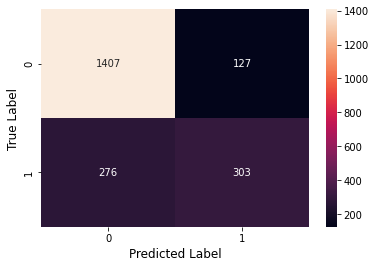

In [17]:
cat_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [18]:
print(metrics.classification_report(Y_test, pred_cat, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.84      0.92      0.87      1534
           1       0.70      0.52      0.60       579

    accuracy                           0.81      2113
   macro avg       0.77      0.72      0.74      2113
weighted avg       0.80      0.81      0.80      2113



ROC_AUC:  0.8594466699542663


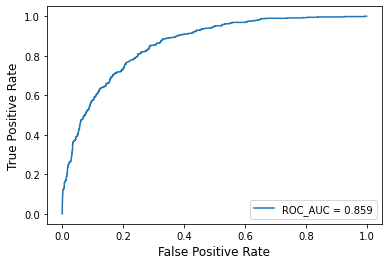

In [19]:
cat_pred_proba = cat_model.predict_proba(X_test)[:,1]

cat_roc_auc = metrics.roc_auc_score(Y_test, cat_pred_proba)
print('ROC_AUC: ', cat_roc_auc)

cat_fpr, cat_tpr, thresholds = metrics.roc_curve(Y_test, cat_pred_proba)

plt.plot(cat_fpr,cat_tpr, label = 'ROC_AUC = %0.3f' % cat_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

## <a id="46">Feature Importance and Plot</a>

Let’s see what features have more importance for the Catboost’s predictions.

In [20]:
pool = Pool(X_train, Y_train)

Feature_importance = pd.DataFrame({'feature_importance': cat_model.get_feature_importance(pool), 
                      'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

Feature_importance

,feature_importance,feature_names
4,15.921144,tenure
26,8.015594,Contract_1
34,8.013065,MonthlyCharges
35,6.980780,TotalCharges
28,6.133374,Contract_3
25,5.620696,StreamingMovies
29,5.081155,PaperlessBilling
10,4.848019,InternetService_2
30,4.254622,PaymentMethod_1
12,3.624722,OnlineSecurity_1


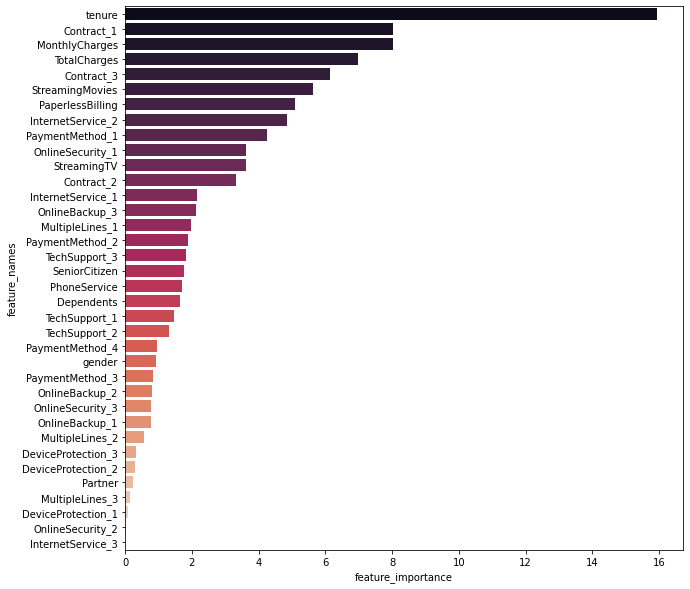

In [21]:
plt.figure(figsize=(10,10))

sns.barplot(x=Feature_importance['feature_importance'], y=Feature_importance['feature_names'], palette = 'rocket')

plt.show()

Select the most importat features to generate all possible combination of the features. 

- Due to large range of numeric features we need to quantise the features values. 
- In this case, we consider every feature which has the more than 4 percent effect on the output as the most important features.

In [22]:
selected_feature_list = []
for i in range(Feature_importance.shape[0]):
    if Feature_importance.feature_importance[i]>4:
        selected_feature_list.append(Feature_importance.feature_names[i])  
selected_feature_list
filename_fil = 'selected_feature_list_drift.sav'
pickle.dump(selected_feature_list, open(filename_fil, 'wb'))
 
# some time later...
 
# load the model from disk
selected_feature_list = pickle.load(open(filename_fil, 'rb'))

Filter the dataset based on the most important features.

In [23]:
selected_feature_data = final_set[selected_feature_list]


Find and scale the feature which has high range of variation in their values

In [24]:

features = []
features_name = selected_feature_list
high_range_feature = []
for col in selected_feature_data:
    if len (selected_feature_data[col].unique())>10:
        min_f = min(selected_feature_data[col].unique())
        max_f = max(selected_feature_data[col].unique())
        
        new_range = np.linspace(min_f, max_f, 20)   
        features.append(new_range)
        high_range_feature.append(col)
    else:
        
        features.append(selected_feature_data[col].unique())
        
high_range_feature
converted_feature_range = 'converted_feature_range_drift.sav'
pickle.dump(high_range_feature, open(converted_feature_range, 'wb'))
 
# some time later...
 
# load the model from disk
high_range_feature = pickle.load(open(converted_feature_range, 'rb'))

Convert the nominal value to the numeric one

Scale the float features with the large range of the train and test data to 20 different scale via closest value.

In [25]:

### for training set
selected_feature_data_c = selected_feature_data.copy()
for index, row in selected_feature_data.iterrows():
    for i in range(len(high_range_feature)) :
        idx = features_name.index(high_range_feature[i])
        absolute_difference_function = lambda list_value : abs(list_value - selected_feature_data.loc[index,high_range_feature[i]])
        closest_value = min(features[idx], key=absolute_difference_function)
        selected_feature_data_c.loc[index, high_range_feature[i]]= closest_value

selected_feature_data_c    

,tenure,InternetService_2,StreamingMovies,Contract_1,Contract_3,PaperlessBilling,PaymentMethod_1,MonthlyCharges,TotalCharges
0,0.000000,0,1,1,0,1,1,44.697368,18.800000
1,3.789474,1,2,1,0,2,1,102.881579,474.905263
2,15.157895,0,3,0,0,2,0,18.250000,474.905263
3,22.736842,0,2,0,0,1,0,44.697368,931.010526
4,68.210526,0,2,0,0,2,0,76.434211,5035.957895
...,...,...,...,...,...,...,...,...,...
7038,0.000000,0,3,1,0,1,0,18.250000,18.800000
7039,0.000000,1,1,1,0,1,1,76.434211,18.800000
7040,68.210526,0,1,0,0,1,0,55.276316,3667.642105
7041,68.210526,0,2,0,1,1,1,81.723684,5948.168421


Generate all possible combination of feature values for testing unoccured combination with drift.

In [26]:
import itertools
combination = list(itertools.product(*features))
len(combination)

768000

In [27]:

df_combination = pd.DataFrame (combination,columns=features_name)

df_combination.sort_index(inplace =True)
df_combination

,tenure,InternetService_2,StreamingMovies,Contract_1,Contract_3,PaperlessBilling,PaymentMethod_1,MonthlyCharges,TotalCharges
0,0.0,0,1,1,0,1,1,18.25,18.800000
1,0.0,0,1,1,0,1,1,18.25,474.905263
2,0.0,0,1,1,0,1,1,18.25,931.010526
3,0.0,0,1,1,0,1,1,18.25,1387.115789
4,0.0,0,1,1,0,1,1,18.25,1843.221053
...,...,...,...,...,...,...,...,...,...
767995,72.0,1,3,0,1,2,0,118.75,6860.378947
767996,72.0,1,3,0,1,2,0,118.75,7316.484211
767997,72.0,1,3,0,1,2,0,118.75,7772.589474
767998,72.0,1,3,0,1,2,0,118.75,8228.694737


Then the next step could be one of these two different paths to measure the drift:

   - Feed all samples one by one and extract their  Corresponding ks-test and p-value;
    
   - Apply the Kmeans and then get the centers and finnaly get the corresponding P-value for each centers.
   
    
    

Define a Drift Model.

In [28]:
cd = TabularDrift(selected_feature_data_c.values, p_val=.05)
filename_drift = 'drift_model_test.sav'
pickle.dump(cd, open(filename_drift, 'wb'))
 
# some time later...
 
# load the model from disk
cd = pickle.load(open(filename_drift, 'rb'))

Test the first scenarios. Check drift for all combination data.

In [29]:
list_dist = []
list_dist_d= []
list_dist_nd= []

list_drift = []
list_drift_index = []
idx =0
cc = 0
for index, row in df_combination.iterrows(): 
    cd_preds = cd.predict(df_combination.iloc[idx].values.reshape(1,df_combination.shape[1]))
    if cd_preds['data']['is_drift']==1:
#         print(cd_preds['data']['is_drift'])
#         print(df_combination.iloc[idx].values)
        list_drift_index.append(idx)
        list_dist_d.append(np.min(cd_preds['data']['p_val']))
        
    else:
        list_dist_nd.append(np.min(cd_preds['data']['p_val']))

    list_drift.append(cd_preds['data']['is_drift'])
    list_dist.append(np.mean(cd_preds['data']['p_val']))
    idx +=1
len (list_drift_index)

38400

Test the second scenarios. Check drift for the kmeans centre.

In this scenarios, we need to apply kmeans on combination data and find the 500 different clusters. 

Then, for each cluster we need to find the nearest sample to the center of cluster.

This is due to the nature of this special kind of drift which considers the p-value for every feature separately (find the rare cases (samples with low p-value) in each feature),

and then combines the results via the Bonferroni or the False Discovery Rate (FDR) correction.  .

In [30]:

kmeans_comb = KMeans(n_clusters=300, random_state=0).fit(combination)
kmeans_comb_center = kmeans_comb.cluster_centers_
#Change the cluster center, by sellecting the nearset value to cluster center as a senter.
closest_comb, _ = pairwise_distances_argmin_min(kmeans_comb.cluster_centers_, df_combination)
new_centre_list_comb = df_combination.iloc[closest_comb]


In [31]:

list_dist = []
list_dist_d= []
list_dist_nd= []

list_drift = []
list_drift_index = []
idx =0
cc = 0
for index, row in new_centre_list_comb.iterrows(): 
    cd_preds = cd.predict(new_centre_list_comb.iloc[idx].values.reshape(1,new_centre_list_comb.shape[1]))
    if cd_preds['data']['is_drift']==1:
#         print(cd_preds['data']['is_drift'])
#         print(new_centre_list_comb.iloc[idx].values)
        list_drift_index.append(idx)
        list_dist_d.append(np.min(cd_preds['data']['p_val']))
        
    else:
        list_dist_nd.append(np.min(cd_preds['data']['p_val']))

    list_drift.append(cd_preds['data']['is_drift'])
    list_dist.append(np.mean(cd_preds['data']['p_val']))
    idx +=1
len (list_drift_index)


1
[6.06315789e+01 0.00000000e+00 2.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 9.23026316e+01
 8.68480000e+03]
1
[7.57894737e+00 0.00000000e+00 2.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 4.46973684e+01
 8.68480000e+03]
1
[6.06315789e+01 0.00000000e+00 2.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 2.88289474e+01
 8.68480000e+03]
1
[7.57894737e+00 0.00000000e+00 2.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 7.11447368e+01
 8.68480000e+03]
1
[1.13684211e+01 0.00000000e+00 2.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.08171053e+02
 8.68480000e+03]
1
[4.16842105e+01 0.00000000e+00 2.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 7.64342105e+01
 8.68480000e+03]
1
[3.78947368e+01 0.00000000e+00 2.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.13460526e+02
 8.68480000e+03]
1
[5.30526316

15

In [32]:
list_dist_d

[0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786,
 0.0039755786]

In [33]:
list_drift_index

[3, 22, 47, 52, 76, 105, 139, 147, 154, 189, 197, 200, 248, 254, 269]

In [34]:
list_drift_index

[3, 22, 47, 52, 76, 105, 139, 147, 154, 189, 197, 200, 248, 254, 269]

Check drrift for all values within a cluster

In [43]:
kmeans_comb.cluster_centers_[list_drift_index[0] ]

array([6.10526316e+01, 5.00000000e-01, 2.00000000e+00, 5.00000000e-01,
       5.00000000e-01, 1.50000000e+00, 5.00000000e-01, 8.99517544e+01,
       8.68480000e+03])

In [44]:
ind = np.where(kmeans_comb.labels_==list_drift_index[0]) 

search_list = df_combination.loc[ind[0]]

In [46]:
idx = 0
for index, row in search_list.iterrows(): 
    # list_dist.append(neigh.kneighbors([df_combination.iloc[index].values]))
    cd_preds = cd.predict(search_list.iloc[idx].values.reshape(1,kmeans_comb_center.shape[1]))
    if cd_preds['data']['is_drift']==1:
        print(cd_preds['data']['is_drift'])


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
